# One-Way Anova
We'll be looking at SAT scores for five different districts ('Borough' in the dataset) in New York City for 2014-2015 school year.

In [312]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [313]:
# Loading data
data = pd.read_csv("data/scores.csv")
# We are not interested with 'Staten Island' district so we drop it from our data
data = data[(data['Borough'] != 'Staten Island')]
data.head()

,School ID,School Name,Borough,Building Code,Street Address,City,State,Zip Code,Latitude,Longitude,...,End Time,Student Enrollment,Percent White,Percent Black,Percent Hispanic,Percent Asian,Average Score (SAT Math),Average Score (SAT Reading),Average Score (SAT Writing),Percent Tested
0,02M260,Clinton School Writers and Artists,Manhattan,M933,425 West 33rd Street,Manhattan,NY,10001,40.75321,-73.99786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06M211,Inwood Early College for Health and Informatio...,Manhattan,M052,650 Academy Street,Manhattan,NY,10002,40.86605,-73.92486,...,3:00 PM,87.0,3.4%,21.8%,67.8%,4.6%,NaN,NaN,NaN,NaN
2,01M539,"New Explorations into Science, Technology and ...",Manhattan,M022,111 Columbia Street,Manhattan,NY,10002,40.71873,-73.97943,...,4:00 PM,1735.0,28.6%,13.3%,18.0%,38.5%,657.0,601.0,601.0,91.0%
3,02M294,Essex Street Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,2:45 PM,358.0,11.7%,38.5%,41.3%,5.9%,395.0,411.0,387.0,78.9%
4,02M308,Lower Manhattan Arts Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,3:00 PM,383.0,3.1%,28.2%,56.9%,8.6%,418.0,428.0,415.0,65.1%


# Data summary

In [314]:
print(data.shape)
data.describe().transpose()

(425, 22)


,count,mean,std,min,25%,50%,75%,max
Zip Code,425.0,10735.955294,540.326238,10001.00000,10451.00000,10472.00000,11220.00000,11694.00000
Latitude,425.0,40.748997,0.078319,40.58085,40.69167,40.74226,40.82230,40.88837
Longitude,425.0,-73.916256,0.064989,-74.03995,-73.97289,-73.92352,-73.87882,-73.72691
Student Enrollment,418.0,674.997608,724.245220,62.00000,354.25000,459.50000,610.00000,5447.00000
Average Score (SAT Math),365.0,431.484932,71.192997,317.00000,385.00000,410.00000,455.00000,754.00000
Average Score (SAT Reading),365.0,423.024658,61.169257,302.00000,386.00000,411.00000,441.00000,697.00000
Average Score (SAT Writing),365.0,416.928767,63.736928,284.00000,381.00000,402.00000,434.00000,693.00000


 Our independent variable (IV) is 'Borough' which is the district you will find the school

In [315]:
data['Borough'].value_counts()

Brooklyn     121
Bronx        118
Manhattan    106
Queens        80
Name: Borough, dtype: int64

Our dependent variable (DV) will be a new feature which we will generate by getting the total score for Average Score (SAT Math), Average Score (SAT Reading) and Average Score (SAT Writing). Let's name our new feature 'total_score' as shown below:

In [316]:
data['total_score'] = data['Average Score (SAT Reading)'] + data['Average Score (SAT Math)']    +  \
                      data['Average Score (SAT Writing)']

# Let's now look at Missing data if any

In [317]:
#Check missing values by percentage
def check_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent*100], axis=1, keys=['Total', 'Percent'])
    return missing_data.loc[missing_data['Percent'] > 0].head(40)

In [318]:
#missing values
check_missing_data(data)

,Total,Percent
total_score,60,14.117647
Average Score (SAT Writing),60,14.117647
Average Score (SAT Reading),60,14.117647
Average Score (SAT Math),60,14.117647
Percent Tested,49,11.529412
Percent Asian,7,1.647059
Percent Hispanic,7,1.647059
Percent Black,7,1.647059
Percent White,7,1.647059
Student Enrollment,7,1.647059


Let's drop rows that have our DV and IV missing

In [319]:
data = data[['Borough', 'total_score']].dropna()    

# Check outliers

In [320]:
def detect_outliers(df, n, features):
        """
        Takes a dataframe df of features and returns a list of the indices
        corresponding to the observations containing more than n outliers according
        to the Tukey method.
        """
        outlier_indices = []

        # iterate over features(columns)
        for col in features:
            # 1st quartile (25%)
            Q1 = np.percentile(df[col], 25)
            # 3rd quartile (75%)
            Q3 = np.percentile(df[col],75)
            # Interquartile range (IQR)
            IQR = Q3 - Q1

            # outlier step
            outlier_step = 1.5 * IQR

            # Determine a list of indices of outliers for feature col
            outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

            # append the found outlier indices for col to the list of outlier indices
            outlier_indices.extend(outlier_list_col)

        # select observations containing more than 2 outliers
        outlier_indices = Counter(outlier_indices)
        multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

        return multiple_outliers

In [321]:
detect_outliers(data, 0, ['total_score'])

[2,
 7,
 18,
 22,
 27,
 29,
 32,
 39,
 55,
 58,
 59,
 61,
 69,
 80,
 105,
 203,
 208,
 241,
 249,
 251,
 277,
 320,
 326,
 356,
 385,
 424,
 434]

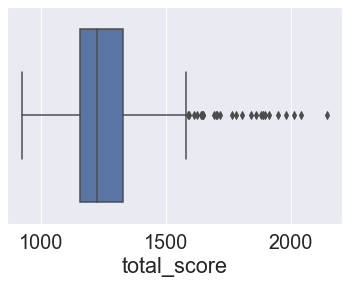

In [323]:
sns.boxplot(x=data['total_score'])

Drop outliers

In [324]:
def drop_outliers_rows_with_percentile(df, column):
    # 1st quartile (25%)
    Q1 = np.percentile(df[column], 25)
    # 3rd quartile (75%)
    Q3 = np.percentile(df[column],75)
    # Interquartile range (IQR)
    IQR = Q3 - Q1

    # outlier step
    outlier_step = 1.5 * IQR
    
    choice = df.loc[(df[column] < (Q3 + outlier_step)) & (df[column] > (Q1 - outlier_step))]

    #df = df[(df[column] < q3plus) & (df[column] > q1minus)]
    return choice

In [325]:
while len(detect_outliers(data, 0, ['total_score']))>0:
    print('==========Running ==============')
    data = drop_outliers_rows_with_percentile(data, 'total_score')

==========Running ==============
==========Running ==============
==========Running ==============


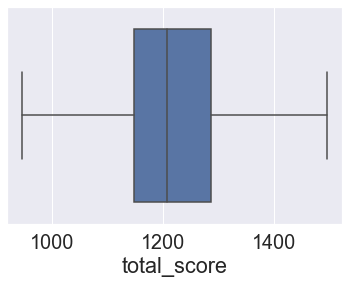

In [326]:
#Check outliers again
sns.boxplot(x=data['total_score'])

Let's now find the mean score of the each district across all schools.

Brooklyn_std : 105.91636031992739
Bronx_std : 88.56336518479604
Manhattan_std : 102.68834607411564
Queens_std : 112.36627331424262


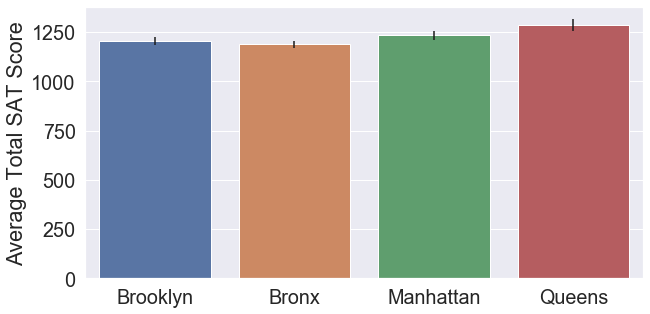

In [327]:
x = ['Brooklyn', 'Bronx', 'Manhattan', 'Queens']
district_dict = {}

#Assigns each test score series to a dictionary key
for district in x:
    district_dict[district] = data[data['Borough'] == district]['total_score']


y = []
yerror = []
#Assigns the mean score and 95% confidence limit to each district
for district in x:
    y.append(district_dict[district].mean())
    yerror.append(1.96*district_dict[district].std()/np.sqrt(district_dict[district].shape[0]))    
    print(district + '_std : {}'.format(district_dict[district].std()))
    
sns.set(font_scale=1.8)
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(x, y, yerr=yerror)
ax.set_ylabel('Average Total SAT Score')
plt.show()

Visualize the means using a boxplot

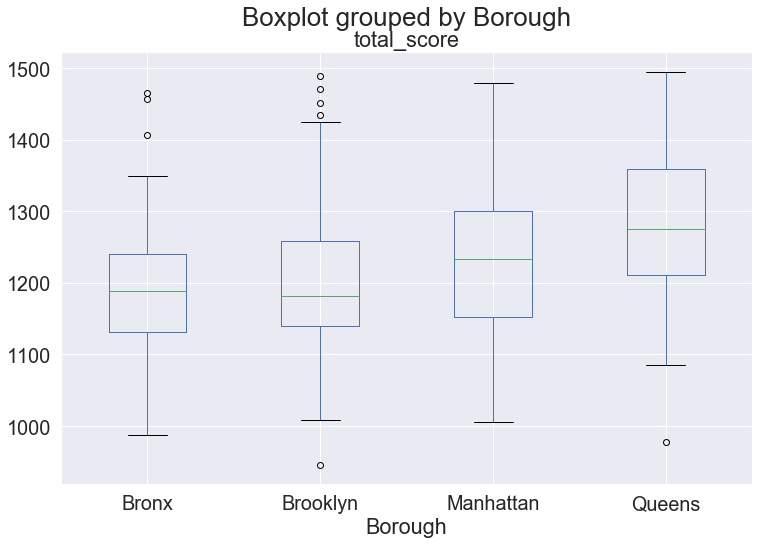

In [328]:
#Create a boxplot
data.boxplot('total_score', by='Borough', figsize=(12, 8))

ctrl = data['total_score'][data.Borough == 'ctrl']

grps = pd.unique(data.Borough.values)
d_data = {grp:data['total_score'][data.Borough == grp] for grp in grps}

k = len(pd.unique(data.Borough))  # number of conditions
N = len(data.values)  # conditions times participants
n = data.groupby('Borough').size()[0] #Participants in each condition

Judging by the Boxplot there are differences in means among the districts. However, we can not tell if the difference is statistically significant.

# The Null and Alternative Hypothesis

There are no significant differences between the groups' mean SAT scores.

H0:μ1=μ2=μ3=μ4

There is a significant difference between the groups' mean SAT scores.

Ha:μi≠μj

Where μi
and μj can be the mean of any group. If there is at least one group with a significant difference with another group, the null hypothesis will be rejected.

Similar to the t-test, we can calculate a score for the ANOVA. Then we can look up the score in the F-distribution and obtain a p-value.

The F-statistic is defined as follows:

F=MSb/MSw

MSb=SSb/K−1

MSw=SSw/N−K

SSb=nk∑(xk¯−xG¯)2

SSw=∑(xi−xk¯)2

Where MSb
is the estimated variance between groups and MSw is the estimated variance within groups, xk¯ is the mean within each group, nk is the sample size for each group, xi is the individual data point, and xG¯ is the total mean.

This is quite a lot of math, fortunately scipy has a function that plugs in all the values for us as shown below

# ANOVA with scipy.stats

In [329]:
stats.f_oneway(
             district_dict['Brooklyn'], district_dict['Bronx'], \
             district_dict['Manhattan'], district_dict['Queens']
)

F_onewayResult(statistic=12.635623683917835, pvalue=7.893957116690208e-08)

The resulting pvalue was less than 0.05. We can reject the null hypothesis and conclude that there is a significant difference between the SAT scores for each district. Even though we've obtained a very low p-value, we cannot make any assumptions about the magnitude of the effect. Also scipy does not calculate SSb and SSw, so it is probably better to write our own code.

In [330]:
districts = ['Brooklyn', 'Bronx', 'Manhattan', 'Queens']

ss_b = 0
for d in districts:
    ss_b += district_dict[d].shape[0] * \
            np.sum((district_dict[d].mean() - data['total_score'].mean())**2)

ss_w = 0
for d in districts:
    ss_w += np.sum((district_dict[d] - district_dict[d].mean())**2)

msb = ss_b/4
msw = ss_w/(len(data)-5)
f=msb/msw
print('F_statistic: {}'.format(f))

F_statistic: 9.447286962432313


# ANOVA with statsmodels
Using statsmodels, we get a bit more information and enter the model as a regression formula

In [331]:
results = ols('total_score ~ C(Borough)', data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_score   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     12.64
Date:                Wed, 26 Feb 2020   Prob (F-statistic):           7.89e-08
Time:                        13:33:49   Log-Likelihood:                -1967.4
No. Observations:                 326   AIC:                             3943.
Df Residuals:                     322   BIC:                             3958.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1188.3053     10.437    113.853      0.000    1167.772    1208.839
C(Borough)[T.Brooklyn]     18.5869     14.505      1.281      0.201      -9.950      47.123
C(Borough)[T.Manhattan]    46.2600     16.091      2.875      0.004      14.603      77.917
C(Borough)[T.Queens]       98.2781     16.775      5.858      0.000      65.275     131.281
==============================================================================
Omnibus:                        6.834   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.670
Skew:                           0.343   Prob(JB):                       0.0356
Kurtosis:                       3.148   Cond. No.                         4.55
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let’s interpret the table. Overall the model is significiant, F(3,322)= 12.64, p < 0.05. This tells us that there is a significant difference in the group means. Coming from the ANOVA framework, the information we are really after in this table it the F-statistic and it’s corresponding p-value.This tells us if we explained a significant amount of the overall variance. 

To test between groups, we need to do some post-hoc testing where we can compare all groups against each other. We are still missing some useful information with this method, we need an ANOVA table.

In [332]:
aov_table = sm.stats.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(Borough),3.922925e+05,3.0,12.635624,7.893957e-08
Residual,3.332330e+06,322.0,NaN,NaN


Let’s break down this ANOVA table. The Borough (district) row is the between groups effect which is the overall experimental effect. The sum of squares for the model is how much variance is explained by our model. The current model explains a significant amount of variance, F(3,322)= 12.64, p < 0.05.

# The Effect Size

We can calculate the magnitude of the effect to determine how large the difference is. There are a few different effect sizes one can use: eta squared, and omega squared. Omega squared is considered a better measure of effect size than eta squared because it is unbiased in it’s calculation. We will use Eta-squared here.

In [333]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

In [334]:
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(Borough),3.922925e+05,3.0,130764.166350,12.635624,7.893957e-08,0.105324,0.09672
Residual,3.332330e+06,322.0,10348.849382,NaN,NaN,NaN,NaN


The general rules of thumb given by Cohen and Miles & Shevlin (2001) for analyzing eta-squared, η2:

Small effect: 0.01

Medium ffect: 0.06

Large effect: 0.14

From our calculations, the effect size 0.105324 for this ANOVA test is "Medium"

# Pairwise Comparisons
# Bonferroni Correction Post-hoc Comparison

Pairwise ttest

In [335]:
# Get all race pairs
district_pairs = []

for district1 in range(3):
    for district2  in range(district1+1,4):
        district_pairs.append((districts[district1], districts[district2]))

# Conduct t-test on each pair
for district1, district2 in district_pairs: 
    print(district1, district2)
    print(stats.ttest_ind(data['total_score'][data['Borough'] == district1], data['total_score'][data['Borough'] == district2])) 

Brooklyn Bronx
Ttest_indResult(statistic=1.331047483704116, pvalue=0.18472753083925217)
Brooklyn Manhattan
Ttest_indResult(statistic=-1.6967961266794305, pvalue=0.0915761954510609)
Brooklyn Queens
Ttest_indResult(statistic=-4.521075398052852, pvalue=1.1916448744493415e-05)
Bronx Manhattan
Ttest_indResult(statistic=-3.0866990572323005, pvalue=0.002381254872156064)
Bronx Queens
Ttest_indResult(statistic=-6.05502593296791, pvalue=1.0421320029615227e-08)
Manhattan Queens
Ttest_indResult(statistic=-2.7465560945004124, pvalue=0.006897869020349316)


First the corrected p-value needs to be calculated. This can be done using the formula:

p-value/no.# of comparisons = 0.05/6 = 0.008333

Now the t-tests that are conducted have to have a p-value less than 0.008333 in order to be considered significant.

=================================================================================================================   

# Tukey’s HSD Post-hoc comparison

group1,group2,meandiff,p-adj,lower,upper,reject
Bronx,Brooklyn,18.5869,0.5666,-18.8735,56.0473,False
Bronx,Manhattan,46.26,0.0223,4.7037,87.8162,True
Bronx,Queens,98.2781,0.001,54.954,141.6022,True
Brooklyn,Manhattan,27.6731,0.3023,-13.2789,68.625,False
Brooklyn,Queens,79.6912,0.001,36.9464,122.4359,True
Manhattan,Queens,52.0181,0.0209,5.6418,98.3944,True


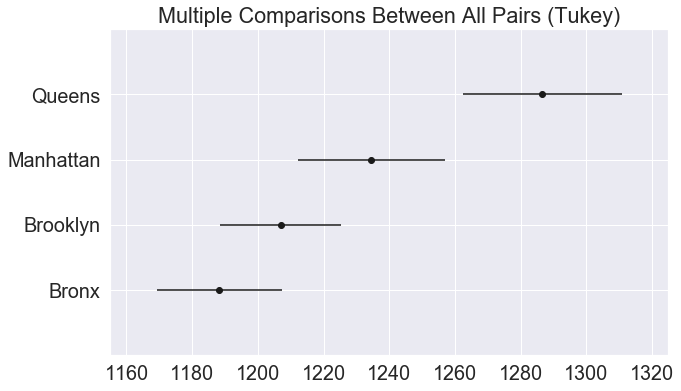

In [337]:
#mc = MultiComparison(data['total_score'], data['Borough'])
#mc_results = mc.tukeyhsd()
#print(mc_results)

# Plot pairwise TukeyHSD comparisons and color by significance level
tukey = pairwise_tukeyhsd(endog=data.total_score,     # Data
                          groups=data.Borough,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary() 

The output of the Tukey test shows the average difference, a confidence interval as well as whether you should reject the null hypothesis for each pair of groups(districts) at the given significance level. In our case, the test suggests we reject the null hypothesis for 4 pairs, with each pair including either "Queens" district. This suggests the score from this district is more likely different from the others. The 95% confidence interval plot reinforces the results visually: "Queens" district's confidence intervals does not overlap any other district's confidence interval.

# Assumptions/Model Diagnostics
When working with linear regression and ANOVA models, the assumptions pertain to the residuals and not the variables themselves.

In [338]:
results.diagn

{'jb': 6.670176701018685,
 'jbpv': 0.035611439783536356,
 'skew': 0.3425074220909507,
 'kurtosis': 3.147684178907809,
 'omni': 6.834389389203184,
 'omnipv': 0.032804332148951634,
 'condno': 4.545537785282993,
 'mineigval': 18.78965671663114}

These are the same diagnostics from the bottom of the regression table from before. The Durban-Watson tests is to detect the presence of autocorrelation (not provided when calling diagnostics this way), Jarque-Bera (jb; jbpv is p-value) tests the assumption of normality, Omnibus (omni; omnipv is p-value) tests the assumption of homogeneity of variance, and the Condition Number (condno) assess multicollinearity. Condition Number values over 20 are indicative of multicollinearity.

# Other ways to check assumptions

# 1. Homogeneity of Variance

We will use the Levene’s test to test for equal variances between groups

In [339]:
stats.levene(data['total_score'][data['Borough'] == 'Brooklyn'],
             data['total_score'][data['Borough'] == 'Bronx'],
             data['total_score'][data['Borough'] == 'Manhattan'],
             data['total_score'][data['Borough'] == 'Queens'])

LeveneResult(statistic=1.5898292305717336, pvalue=0.1917065148675515)

Levene’s test for homogeneity of variance is not significant which indicates that the groups have approximately equal variances.

# 2. Normality

The assumption of normality is tested on the residuals as a whole which is how the diagnostic information provided by statsmodels tests the residuals.

In [340]:
stats.shapiro(results.resid)

(0.9864307045936584, 0.003728637006133795)

The results from the Shapiro-Wilk test is statistically significant which indicates that the residuals are not normally distributed.

# The Normality assumption was violated, so what next?

It is important to note that ANOVA is not robust to violations to the assumption of independence.  This is to say, that even if you violate the assumptions of homogeneity or normality, you can conduct the test and basically trust the findings.  However, the results of the ANOVA are invalid if the independence assumption is violated.  In general, with violations of homogeneity the analysis is considered robust if you have approximately equal sized groups.  With violations of normality, continuing with the ANOVA is generally ok if you have a large sample size (30 or more) for each group (The ratio of largest group:smallest group should not be greater than 3).

In [341]:
data['Borough'].value_counts()

Brooklyn     102
Bronx         95
Manhattan     69
Queens        60
Name: Borough, dtype: int64

Looking at our groups above, they are approximately equal sized groups. This means that we can trust our test results